In [140]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [141]:
from multi_scale_edge_detection.MultiScaleContourDetector import multi_scale_contour_detection_with_inhibition
from scipy.spatial import distance

In [142]:
# Path to the video file
video_path = 'boat.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Initialize an empty list to store frames
frames = []

# Read the video frame by frame
while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Append the frame to the frames list
    frames.append(frame)

# Release the video capture object
cap.release()

# Convert the list of frames to a numpy array
frames_array = np.array(frames)

# Print the shape of the frames array
print("Shape of frames array:", frames_array.shape)

Shape of frames array: (300, 720, 1280, 3)


In [143]:
# Path to the video file
video_path = 'boat.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Initialize an empty list to store gray frames
gray_frames = []

# Read the video frame by frame
while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Append the frame to the frames list
    gray_frames.append(gray_frame)

# Release the video capture object
cap.release()

# Convert the list of frames to a numpy array
frames_array = np.array(frames)

# Print the shape of the frames array
print("Shape of frames array:", frames_array.shape)

Shape of frames array: (300, 720, 1280, 3)


In [144]:
normalized_frames = []

# Iterate over each frame array
for frame in frames_array:
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Normalize the pixel values to range [0, 1]
    normalized_frame = gray_frame / 255.0
    
    # Append the normalized grayscale frame to the list
    normalized_frames.append(normalized_frame)

print("Normalization and storing completed.")

Normalization and storing completed.


In [ ]:
# Create an empty list to store the results
results_list = []

# Iterate over each normalized grayscale frame
for frame in normalized_frames:
    # Apply the function to the current frame and store the result
    result = multi_scale_contour_detection_with_inhibition(frame, N=8, sigma=1, alpha=0.00001)
    
    # Append the result to the results_list
    results_list.append(result)

print("Multi-scale contour detection completed for all frames.")

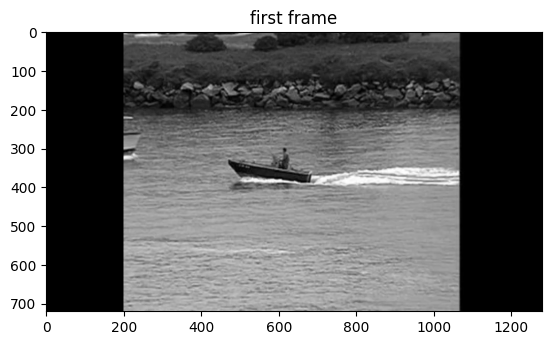

In [146]:
frame1 = gray_frames[0]
plt.imshow(frame1 , cmap='gray')
plt.title('first frame')
plt.show()

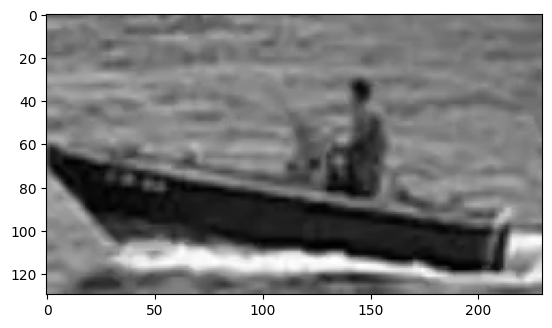

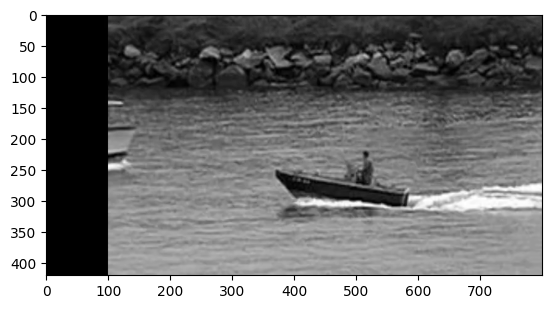

In [147]:
temp1 = frame1[270:400,470:700]
temp2 = frame1[80:500,100:900]
plt.figure(0)
plt.imshow(temp1, cmap="gray")
plt.figure(1)
plt.imshow(temp2, cmap="gray")

In [167]:
def get_hog_distance(image1, image2):

    # Read the images
    if type(image1)==str:
        img1 = cv2.imread(image1, cv2.IMREAD_UNCHANGED)
    else: img1 = image1
    if type(image2)==str:
        img2 = cv2.imread(image2, cv2.IMREAD_UNCHANGED)
    else: img2 = image2


    # img1 = img1.astype(np.uint8)
    # img2 = img2.astype(np.uint8)

    # Convert to float
    # img1_float = img1.astype(float)
    # img2_float = img2.astype(float)

    # define each block as 4x4 cells of 64x64 pixels each
    cell_size = (64, 64)        # h x w in pixels
    block_size = (4, 4)         # h x w in cells
    win_size = (8, 6)           # h x w in cells

    nbins = 9  # number of orientation bins
    image1_size = img1.shape[:2]  # h x w in pixels

    # create HOG objects
    hog1 = cv2.HOGDescriptor(
        _winSize=(win_size[1] * cell_size[1],
                win_size[0] * cell_size[0]),
        _blockSize=(block_size[1] * cell_size[1],
                    block_size[0] * cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    hog2 = cv2.HOGDescriptor(
        _winSize=(win_size[1] * cell_size[1],
                win_size[0] * cell_size[0]),
        _blockSize=(block_size[1] * cell_size[1],
                    block_size[0] * cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    n_cells = (image1_size[0] // cell_size[0], image1_size[1] // cell_size[1])

    # find features as a 1xN vector, then reshape into spatial hierarchy
    hog1_feats = hog1.compute(img1)
    hog1_feats = hog1_feats.reshape(
        n_cells[1] - win_size[1] + 1,
        n_cells[0] - win_size[0] + 1,
        win_size[1] - block_size[1] + 1,
        win_size[0] - block_size[0] + 1,
        block_size[1],
        block_size[0],
        nbins)
    
    hog2_feats = hog2.compute(img2)
    hog2_feats = hog2_feats.reshape(
        n_cells[1] - win_size[1] + 1,
        n_cells[0] - win_size[0] + 1,
        win_size[1] - block_size[1] + 1,
        win_size[0] - block_size[0] + 1,
        block_size[1],
        block_size[0],
        nbins)

    # Compute absolute difference between hog features
    diff = cv2.absdiff(hog1_feats,hog2_feats)

    # Compute similarity score
    similarity = np.sum(diff)
    return similarity

    

def template_hog_matching(template, target):
    # Find template dimensions
    th, tw = template.shape[:2]

    # Compute the barycenter of the target image
    ty, tx = target.shape[:2]
    barycenter_x = tx // 2
    barycenter_y = ty // 2

    # Compute the size of the ROI
    roi_size_x = tw * 2
    roi_size_y = th * 2

    # Define the ROI boundaries
    roi_x = max(0, barycenter_x - roi_size_x // 2)
    roi_y = max(0, barycenter_y - roi_size_y // 2)
    roi_width = min(tx - roi_x, roi_size_x)
    roi_height = min(ty - roi_y, roi_size_y)

    # Slide template over the target image within the ROI and calculate similarity scores
    best_similarity = float('inf')
    best_location = None
    for y in range(roi_y, roi_y + roi_height - th):
        for x in range(roi_x, roi_x + roi_width - tw):
            roi = target[y:y+th, x:x+tw]
            plt.figure(0)
            plt.imshow(template, cmap="gray")
            plt.figure(1)
            plt.imshow(roi, cmap="gray")

            similarity = get_hog_distance(template, roi)
            if similarity < best_similarity:
                best_similarity = similarity
                best_location = (x, y)

    return best_location

    

# Testing get_hog_distance function

(512, 512)


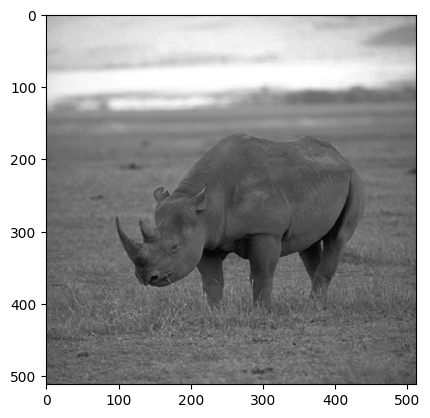

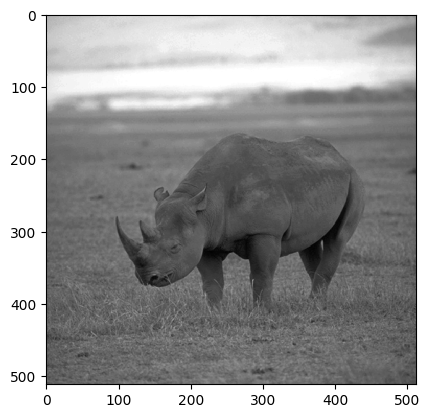

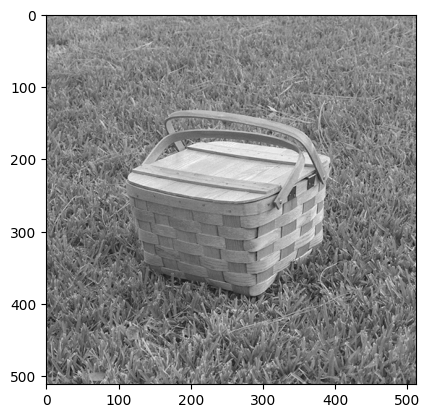

In [203]:
rino = cv2.imread('database/images/rino.pgm',cv2.IMREAD_UNCHANGED)
## adding noise to the image 
noise = np.random.normal(0, 1, rino.shape)
rino_noisy = (1-0.05)*rino + 0.05*noise
rino_2 = rino_noisy.astype(np.uint8)
basket = cv2.imread('database/images/basket.pgm',cv2.IMREAD_UNCHANGED)

plt.figure(0)
plt.imshow(rino, cmap="gray")
plt.figure(1)
plt.imshow(rino_2, cmap="gray")
plt.figure(2)
plt.imshow(basket, cmap="gray")
print(rino.shape)

In [188]:
# Difference between images A1 and A2
get_hog_distance(rino,rino_2)

4.8217893

In [189]:
# Difference between images A1 and B
get_hog_distance(rino,basket)

211.3577

In [190]:
# Difference between images A2 and B
get_hog_distance(rino_2,basket)

209.9727

## Testing for cropped images

4.743081

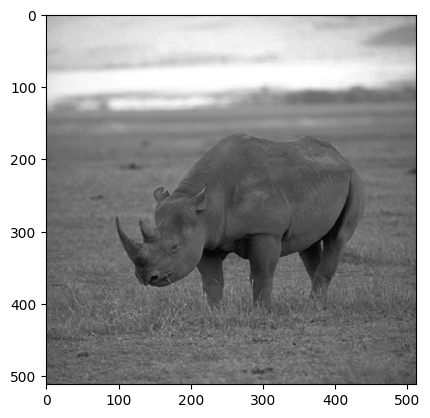

In [210]:
rino_cropped = rino[0:512,0:512]
rino_cropped=rino_cropped.astype(np.uint8)
rino_2_cropped = rino_2[0:512,0:512]
rino_2_cropped=rino_2_cropped.astype(np.uint8)
plt.imshow(rino_cropped,cmap='gray')
get_hog_distance(rino_cropped,rino_2_cropped)

# Testing template matching

## Test 1

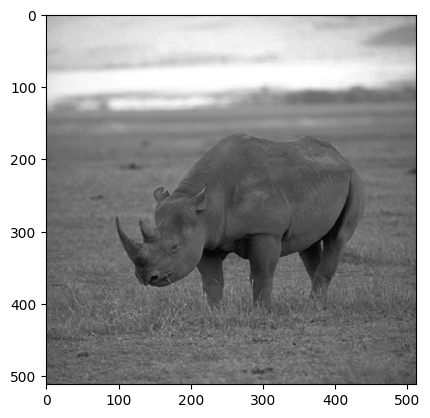

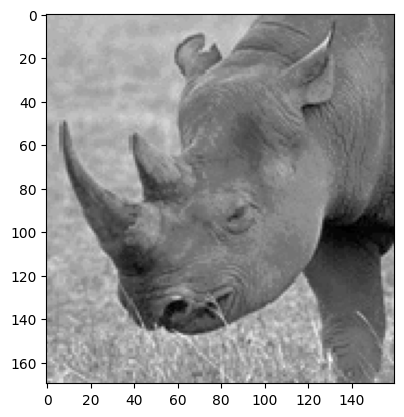

In [192]:
target_1 = rino
template_1 = rino[230:400,90:250]
plt.figure(0)
plt.imshow(target_1, cmap="gray")
plt.figure(1)
plt.imshow(template_1, cmap="gray")

In [194]:
get_hog_distance(target_1,template_1)

error: Unknown C++ exception from OpenCV code

error: Unknown C++ exception from OpenCV code

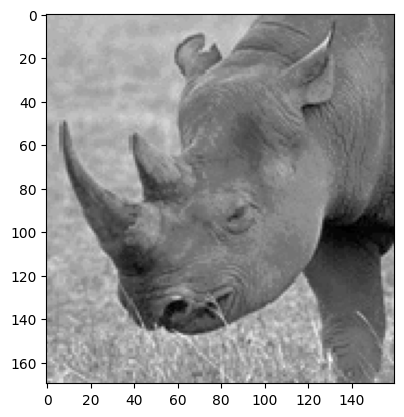

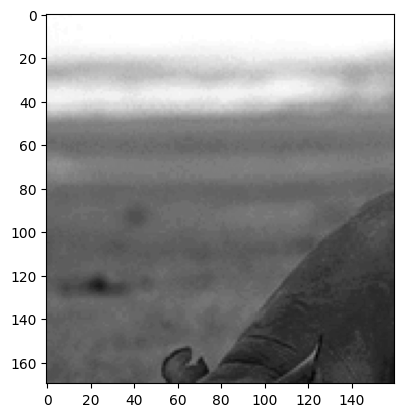

In [211]:
if __name__ == "__main__":
    # Load images
    template_img = template_1
    target_img = target_1

    # Find the best location for template matching
    best_loc = template_hog_matching(template_img, target_img)

    # Draw rectangle around the matched region
    tw, th = template_img.shape[:2]
    cv2.rectangle(target_img, best_loc, (best_loc[0] + tw, best_loc[1] + th), (0, 255, 0), 2)

    # Display result
    cv2.imshow('Template Matching', target_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Test 2

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix.cpp:767: error: (-215:Assertion failed) 0 <= _rowRange.start && _rowRange.start <= _rowRange.end && _rowRange.end <= m.rows in function 'cv::Mat::Mat'


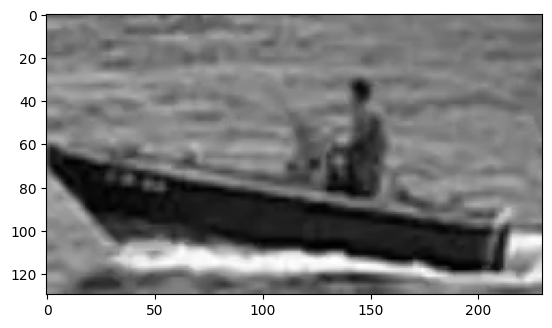

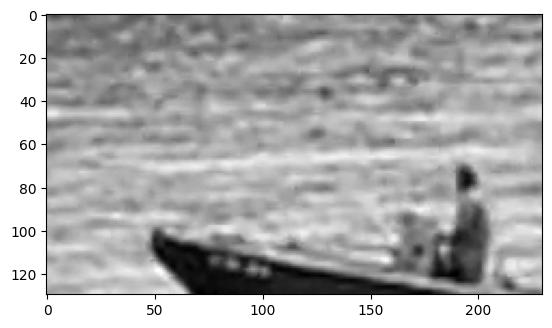

In [171]:
if __name__ == "__main__":
    # Load images
    template_img = frame1[270:400,470:700]
    target_img = normalized_frames[10]

    # Find the best location for template matching
    best_loc = template_hog_matching(template_img, target_img)

    # Draw rectangle around the matched region
    tw, th = template_img.shape[:2]
    cv2.rectangle(target_img, best_loc, (best_loc[0] + tw, best_loc[1] + th), (0, 255, 0), 2)

    # Display result
    cv2.imshow('Template Matching', target_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()